In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging,
    GenerationConfig
)

In [3]:
# Model identifier
model_name = "nlpbmu/Llama-2-7b-chat-finetune"

device_map = {"": 0}
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
use_4bit = True

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# # Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

In [4]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc \
  | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" \
  | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [859 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:11 https://ngrok-agent.s3.amazonaws.com buster/main amd64 Packages [5,220 B]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
G

In [5]:
!pip install ngrok
!pip install pyngrok
!pip install flask_cors
!pip install psycopg2
!pip install reportlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.5 MB/s eta 0:00:00


In [8]:
!ngrok config add-authtoken
# !ngrok http --domain=crack-gannet-full.ngrok-free.app 80

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


 * Tunnel URL: NgrokTunnel: "https://0400-35-240-186-217.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:__main__:Exception on /daily_summary [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask_cors/extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functio

Error: Unable to fetch data from the URL.


ERROR:__main__:Exception on /daily_summary [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask_cors/extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-9-0be3d780b6a2>", line 157, in daily_summary
    generate_report(insights)
  File "<ipython-input-9-0be3d780b6a2>", line 355, in generate_report
    

Error: Unable to fetch data from the URL.


ERROR:__main__:Exception on /daily_summary [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask_cors/extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-10-0be3d780b6a2>", line 157, in daily_summary
    generate_report(insights)
  File "<ipython-input-10-0be3d780b6a2>", line 355, in generate_report
  

Error: Unable to fetch data from the URL.


INFO:werkzeug:127.0.0.1 - - [22/Jul/2024 06:03:35] "GET /daily_summary HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2024 06:05:57] "GET /daily_summary HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2024 06:06:58] "GET /daily_summary HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2024 06:07:12] "GET /daily_summary HTTP/1.1" 200 -


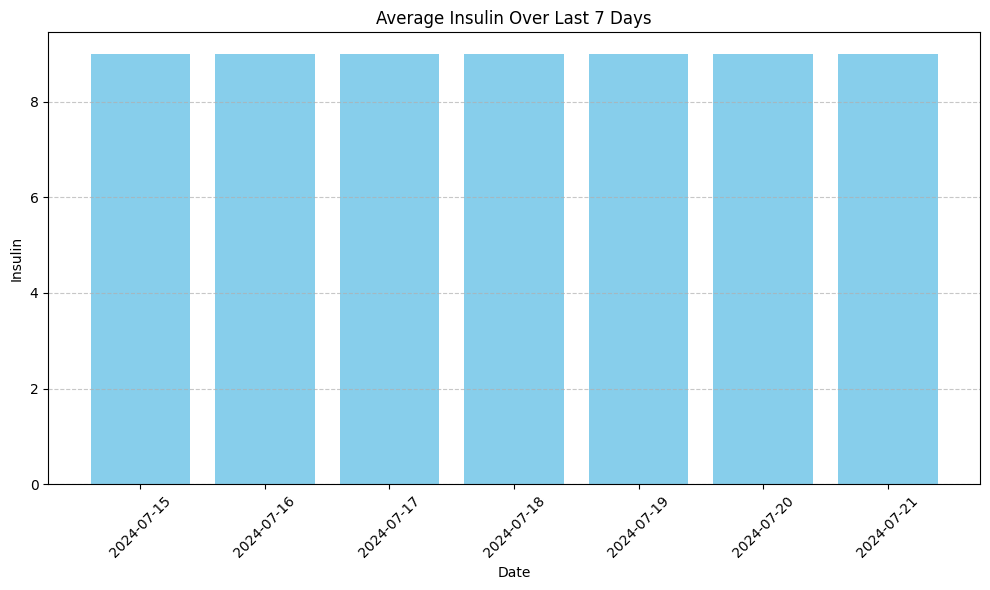

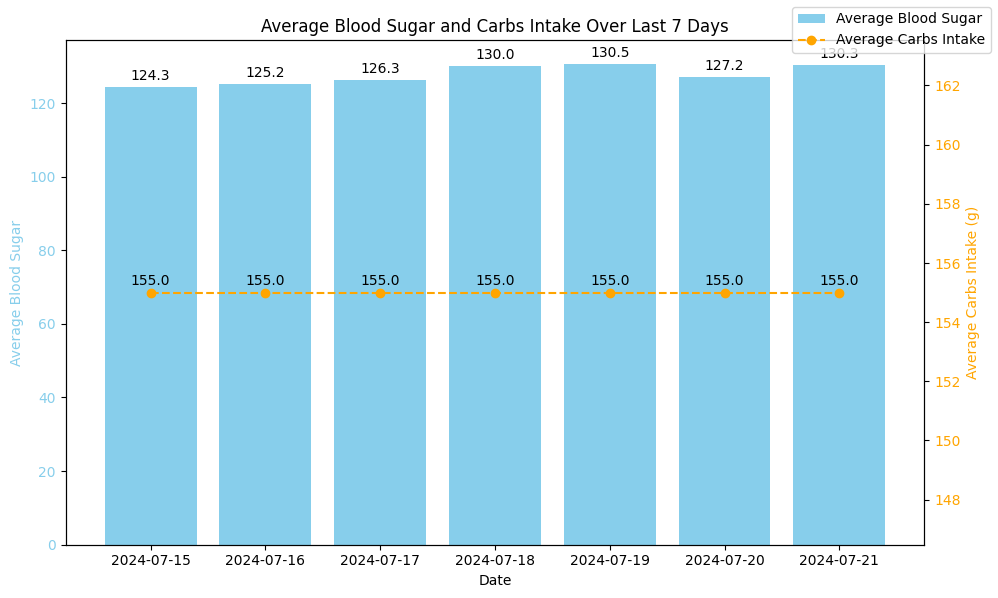

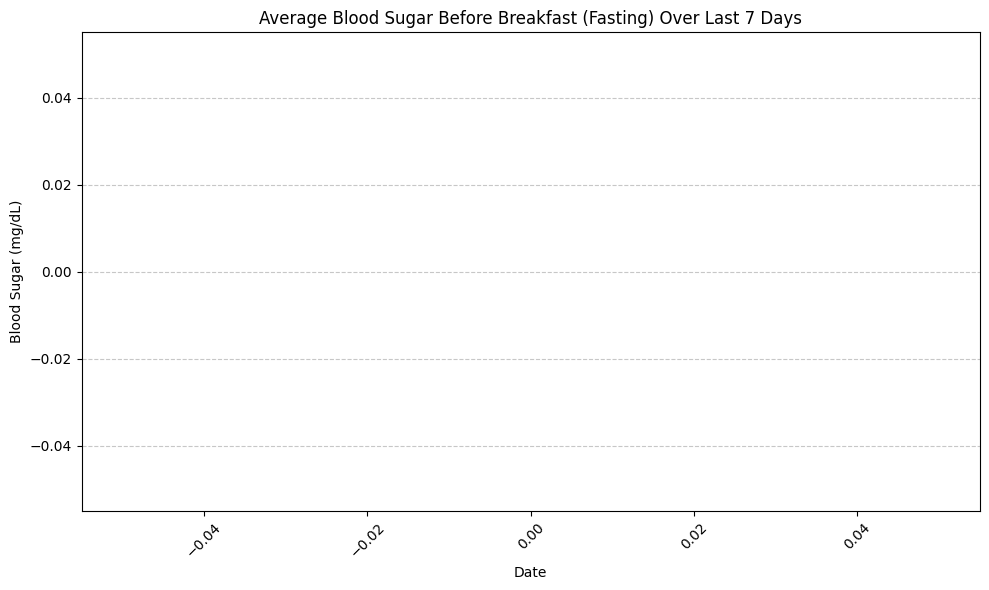

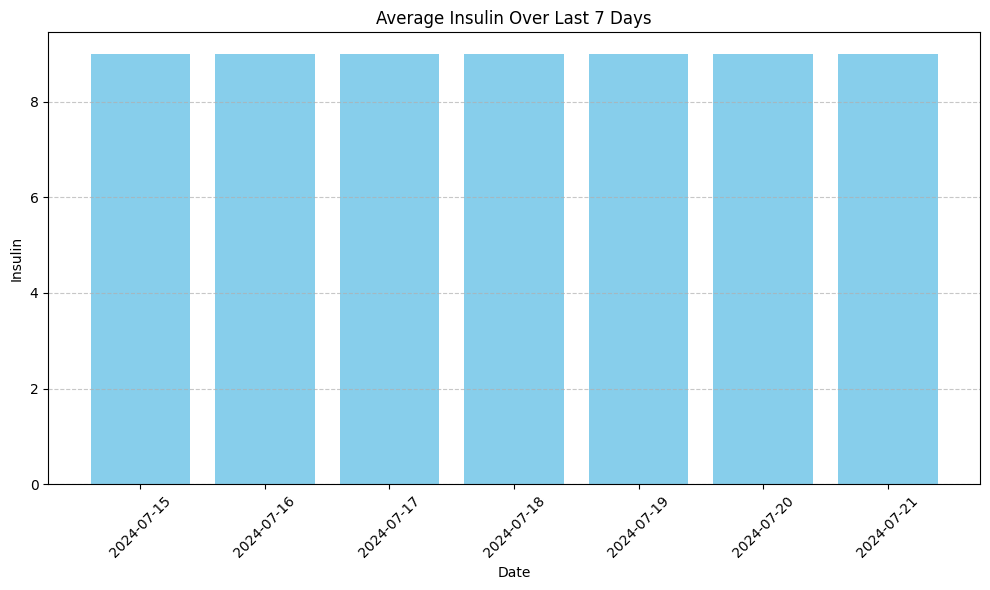

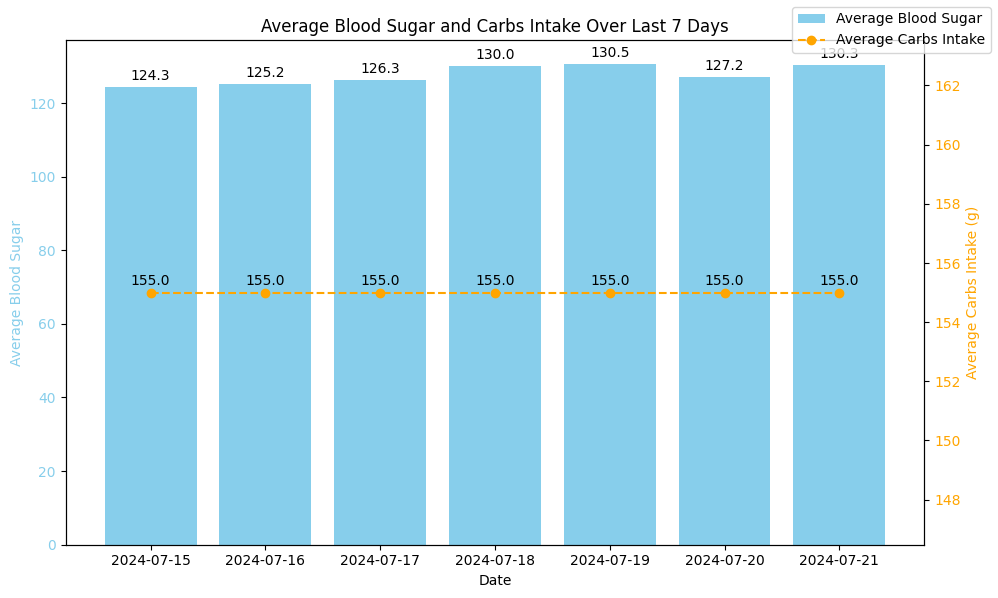

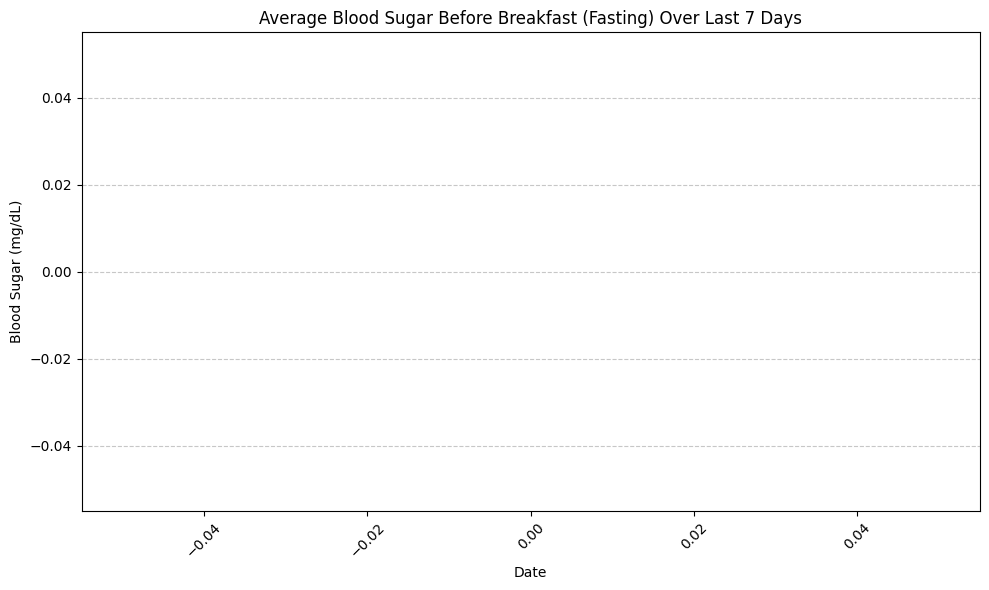

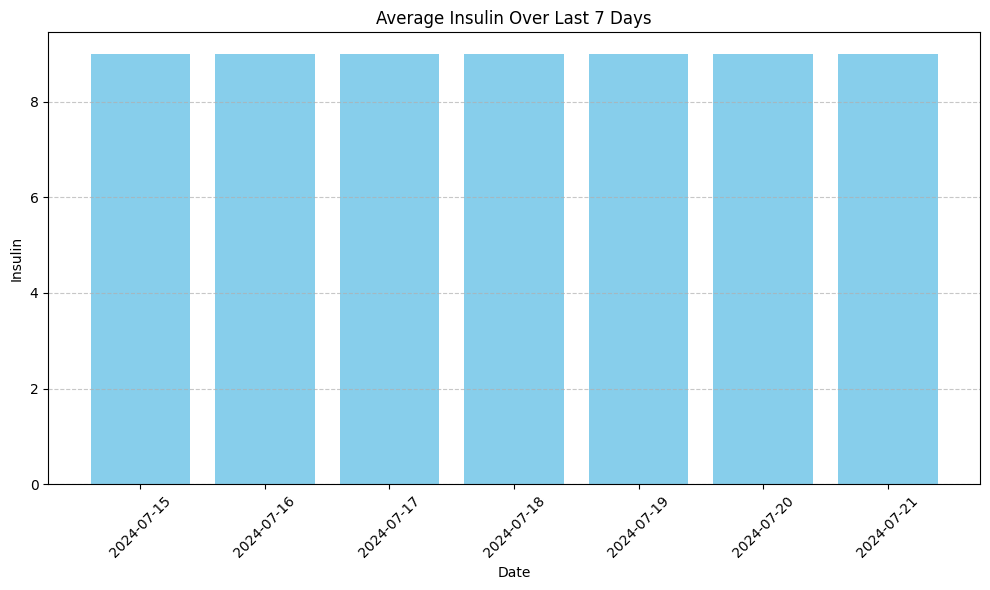

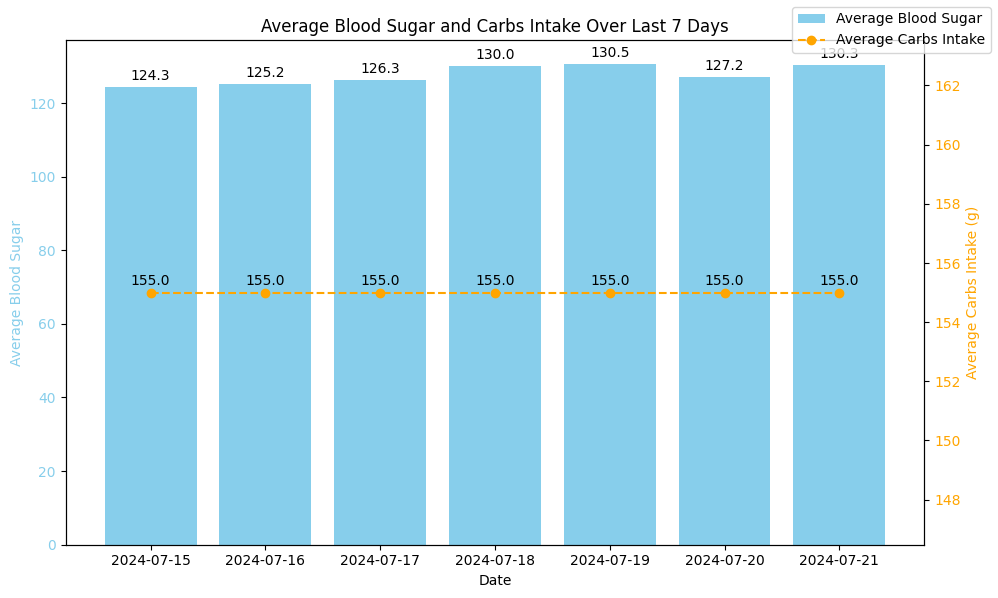

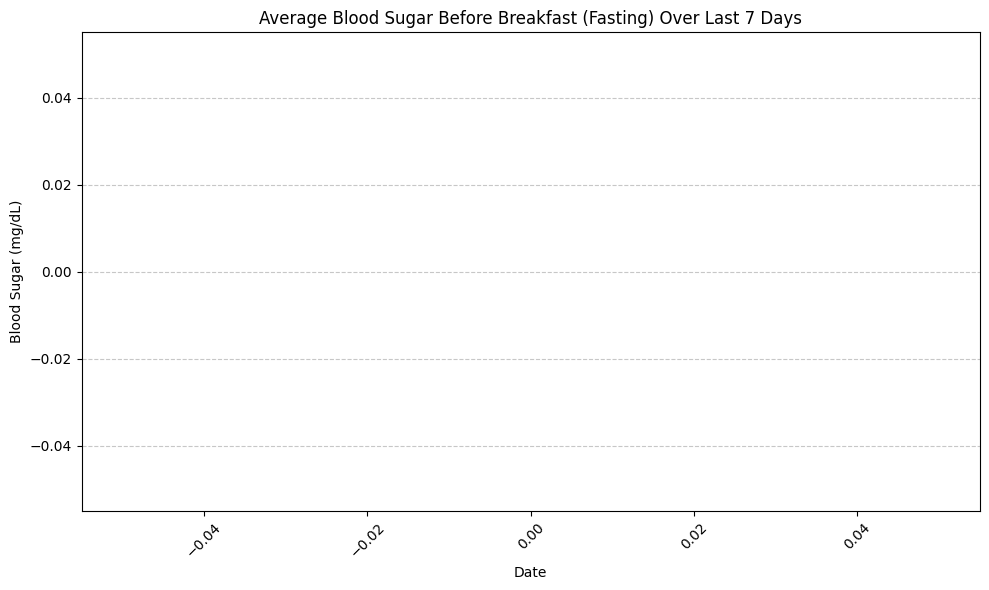

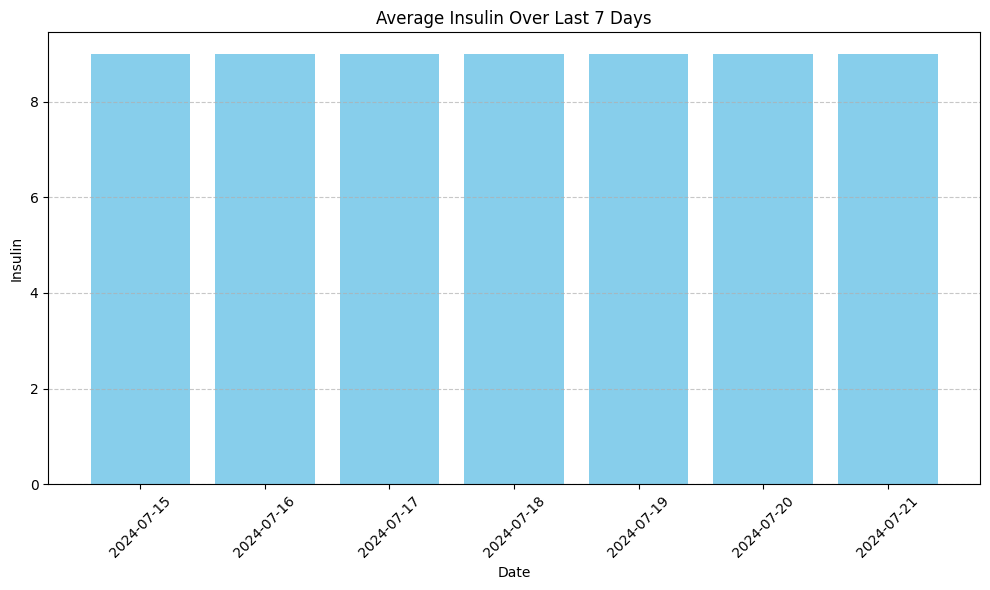

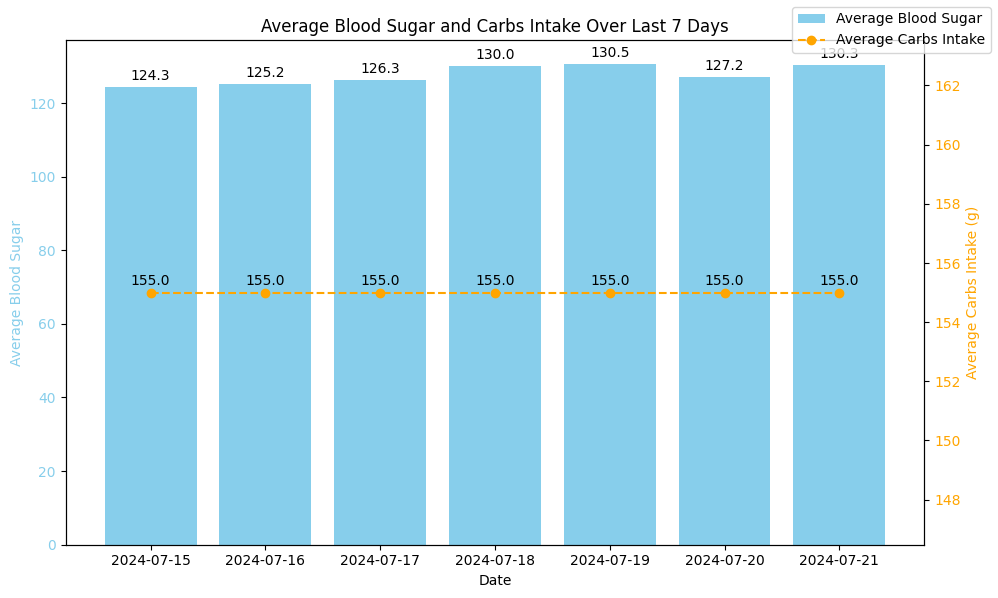

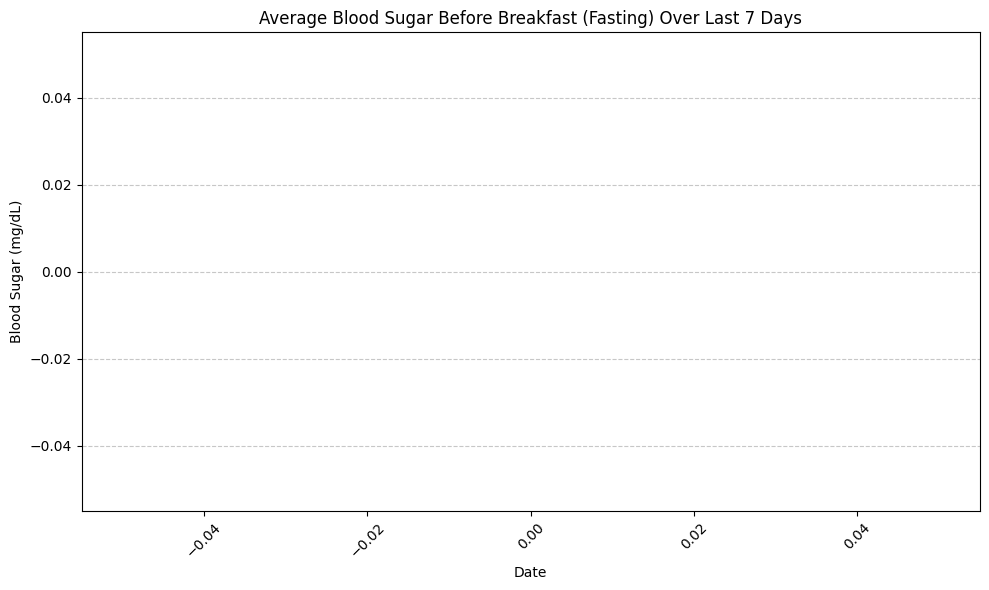

In [11]:
from flask import Flask, request, jsonify,send_file
from flask_cors import CORS
from pyngrok import ngrok
import psycopg2
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, Paragraph, Spacer, KeepInFrame
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import Image
from datetime import datetime, timedelta

app = Flask(__name__)
CORS(app, resources={r"/*": {"origins": "*"}})

db_config = {
    'dbname': '',
    'user': '',
    'password': '',
    'host': '',
    'port': ''
}

generation_config = GenerationConfig(
    max_length=250,
    max_new_tokens=500
)

@app.route('/daily_summary', methods=['GET'])
def daily_summary():

    phonenumber = request.args.get('phonenumber')

    # Calculate start and end dates for the last 7 days
    # end_date = datetime.now().date()
    # start_date = end_date - timedelta(days=6)  # 6 days ago

    start_date = "2024-07-15"
    end_date = "2024-07-21"

    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()

    data_by_date = {}

    # Define all possible keys
    all_keys = [
        'before_breakfast', 'after_breakfast', 'before_lunch', 'after_lunch',
        'before_dinner', 'after_dinner', 'other', 'Meal Bolus', 'Basal Insulin',
        'Correction Dose', 'activity_duration', 'carb_total'
    ]

    # Fetch and aggregate blood sugar data
    cursor.execute('''
      SELECT
          date,
          ROUND(AVG(CASE WHEN meal_type = 'before_breakfast' THEN blood_sugar END)::numeric, 2) AS before_breakfast,
          ROUND(AVG(CASE WHEN meal_type = 'after_breakfast' THEN blood_sugar END)::numeric, 2) AS after_breakfast,
          ROUND(AVG(CASE WHEN meal_type = 'before_lunch' THEN blood_sugar END)::numeric, 2) AS before_lunch,
          ROUND(AVG(CASE WHEN meal_type = 'after_lunch' THEN blood_sugar END)::numeric, 2) AS after_lunch,
          ROUND(AVG(CASE WHEN meal_type = 'before_dinner' THEN blood_sugar END)::numeric, 2) AS before_dinner,
          ROUND(AVG(CASE WHEN meal_type = 'after_dinner' THEN blood_sugar END)::numeric, 2) AS after_dinner,
          ROUND(AVG(CASE WHEN meal_type = 'other' THEN blood_sugar END)::numeric, 2) AS other
      FROM blood_sugar_records
      WHERE phonenumber = %s AND date >= %s AND date <= %s
      GROUP BY date
      ''', (phonenumber, start_date, end_date,))

    for row in cursor.fetchall():
        date = str(row[0])
        data_by_date[date] = {key: row[i + 1] if row[i + 1] is not None else None for i, key in enumerate(all_keys[:7])}

    # Fetch and aggregate insulin data
    cursor.execute('''
        SELECT
            date,
            ROUND(SUM(CASE WHEN type = 'Meal Bolus' THEN insulin END)::numeric, 2) AS Meal_Bolus,
            ROUND(SUM(CASE WHEN type = 'Basal Insulin' THEN insulin END)::numeric, 2) AS Basal_Insulin,
            ROUND(SUM(CASE WHEN type = 'Correction Dose' THEN insulin END)::numeric, 2) AS Correction_Dose
        FROM insulin_records
        WHERE phonenumber = %s AND date >= %s AND date <= %s
        GROUP BY date
    ''', (phonenumber, start_date, end_date,))

    for row in cursor.fetchall():
        date = str(row[0])
        data_by_date.setdefault(date, {}).update({key: row[i + 1] if row[i + 1] is not None else None for i, key in enumerate(all_keys[7:10])})

    # Fetch and aggregate activity data
    cursor.execute('''
        SELECT
            date,
            ROUND(SUM(EXTRACT(EPOCH FROM duration::interval))::numeric, 2) AS activity_duration
        FROM activity_records
        WHERE phonenumber = %s AND date >= %s AND date <= %s
        GROUP BY date
    ''', (phonenumber, start_date, end_date,))

    for row in cursor.fetchall():
        date = str(row[0])
        data_by_date.setdefault(date, {}).update({'activity_duration': row[1]})

    # Fetch and aggregate carb data
    cursor.execute('''
        SELECT
            date,
            ROUND(SUM(carb)::numeric, 2) AS carb_total
        FROM meal_records
        WHERE phonenumber = %s AND date >= %s AND date <= %s
        GROUP BY date
    ''', (phonenumber, start_date, end_date,))

    for row in cursor.fetchall():
        date = str(row[0])
        data_by_date.setdefault(date, {}).update({'carb_total': row[1]})

    conn.close()

    # Fill in missing keys with null values
    for date_entry in data_by_date.values():
        for key in all_keys:
            date_entry.setdefault(key, None)

    # Constructing the prompt
    prompt = "Patient's 1-week blood sugar data:\n"
    # Append data to the prompt
    for date, data in data_by_date.items():
        prompt += f"Date: {date}\n"
        for key, value in data.items():
            # Check if value is None to avoid TypeError
            if value is not None:
                prompt += f"{key}: {value:.2f}\n"
            else:
                prompt += f"{key}: None\n"

    prompt += "Provide insights on the trends in blood sugar levels and any recommendations for management. Everything in 100 WORDS and in 3 points."

    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, generation_config=generation_config)
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    generated_text = result[0]['generated_text']

    # Create Graphs
    create_graphs()

    marker = "[/INST]"
    # Find the index of the marker
    index = generated_text.find(marker)
    if index != -1:
        # Extract the text after the marker
        insights = generated_text[index + len(marker):].strip()
    else:
        print("Marker not found in the text.")

    generate_report(insights)

    pdf_file_path = '/content/report.pdf'
    # Return the PDF file as a response
    return send_file(pdf_file_path, as_attachment=True)

    # return jsonify({"insights": insights})

@app.route('/', methods=['GET'])
def home():
    # Generating insights
    generated_text = "Server is Live"
    return jsonify({"generated_text": generated_text})

def create_graphs():

  conn = psycopg2.connect(**db_config)
  cur = conn.cursor()

  # query = "SELECT date, AVG(insulin) FROM insulin_records WHERE date >= CURRENT_DATE - INTERVAL '7 days' GROUP BY date"
  query = '''
  SELECT date, AVG(insulin)
  FROM insulin_records
  WHERE date BETWEEN '2024-07-15' AND '2024-07-21'
  GROUP BY date;
  '''
  cur.execute(query)
  data = cur.fetchall()

  # Extract dates and average blood sugar levels from the fetched data
  dates = [row[0] for row in data]
  avg_insulin = [row[1] for row in data]

  # Plot the data
  plt.figure(figsize=(10, 6))
  plt.bar(dates, avg_insulin, color='skyblue')
  plt.title('Average Insulin Over Last 7 Days')
  plt.xlabel('Date')
  plt.ylabel('Insulin')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.savefig('graph1.png')


  # Fetch data from the database for blood sugar
  # cur.execute("SELECT date, AVG(blood_sugar) AS avg_blood_sugar FROM blood_sugar_records WHERE date >= CURRENT_DATE - INTERVAL '7 days' GROUP BY date")
  cur.execute("SELECT date, AVG(blood_sugar) AS avg_blood_sugar FROM blood_sugar_records WHERE date BETWEEN '2024-07-15' AND '2024-07-21' GROUP BY date")
  blood_sugar_data = cur.fetchall()

  # Extract dates and average blood sugar levels
  blood_sugar_dates = [row[0] for row in blood_sugar_data]
  avg_blood_sugar = [row[1] for row in blood_sugar_data]

  # Fetch data from the database for carbs
  # cur.execute("SELECT date, SUM(carb) AS sum_carb FROM meal_records WHERE date >= CURRENT_DATE - INTERVAL '7 days' GROUP BY date")
  cur.execute("SELECT date, SUM(carb) AS sum_carb FROM meal_records WHERE date BETWEEN '2024-07-15' AND '2024-07-21' GROUP BY date")
  carbs_data = cur.fetchall()

  # Extract dates and average carb intake
  carbs_dates = [row[0] for row in carbs_data]
  avg_carb = [row[1] for row in carbs_data]

  # Sort the data by dates
  blood_sugar_dates, avg_blood_sugar = zip(*sorted(zip(blood_sugar_dates, avg_blood_sugar)))
  carbs_dates, avg_carb = zip(*sorted(zip(carbs_dates, avg_carb)))

  # Plot the data
  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot blood sugar data on primary y-axis
  color = 'skyblue'
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Average Blood Sugar', color=color)
  bars = ax1.bar(blood_sugar_dates, avg_blood_sugar, color=color, label='Average Blood Sugar')
  ax1.tick_params(axis='y', labelcolor=color)

  # Create secondary y-axis for carb intake
  ax2 = ax1.twinx()
  color = 'orange'
  ax2.set_ylabel('Average Carbs Intake (g)', color=color)
  line = ax2.plot(carbs_dates, avg_carb, color=color, marker='o', linestyle='--', label='Average Carbs Intake')
  ax2.tick_params(axis='y', labelcolor=color)

  # Add values on top of each bar (blood sugar) and data point (carbs)
  for bar in bars:
      height = bar.get_height()
      ax1.annotate(f'{height:.1f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom')

  for date, value in zip(carbs_dates, avg_carb):
      ax2.annotate(f'{value:.1f}',
                  xy=(date, value),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom')

  # Add legend
  fig.legend(loc='upper right')

  # Show plot
  plt.title('Average Blood Sugar and Carbs Intake Over Last 7 Days')
  plt.tight_layout()
  plt.savefig('graph2.png')

  # query = "SELECT date, AVG(blood_sugar) AS avg_blood_sugar FROM blood_sugar_records WHERE meal_type = 'before_breakfast' AND date >= CURRENT_DATE - INTERVAL '7 days' GROUP BY date"
  query = "SELECT date, AVG(blood_sugar) AS avg_blood_sugar FROM blood_sugar_records WHERE meal_type = 'before_breakfast' AND date BETWEEN '2024-07-15' AND '2024-07-21' GROUP BY date"

  cur.execute(query)
  data = cur.fetchall()

  # Extract dates and average blood sugar levels from the fetched data
  dates = [row[0] for row in data]
  avg_blood_sugar = [row[1] for row in data]

  # Plot the data
  plt.figure(figsize=(10, 6))
  plt.bar(dates, avg_blood_sugar, color='skyblue')
  plt.title('Average Blood Sugar Before Breakfast (Fasting) Over Last 7 Days')
  plt.xlabel('Date')
  plt.ylabel('Blood Sugar (mg/dL)')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.savefig('graph3.png')

  # Close cursor and connection
  cur.close()
  conn.close()

def generate_report(insights_text):

  insights_text = str(insights_text)

  # Hardcoded patient information
  patient_name = "John Doe"
  patient_age = 35
  patient_gender = "Male"

  # Calculate start and end dates for the last 7 days
  end_date = datetime.now().date()
  start_date = end_date - timedelta(days=6)  # 6 days ago

  start_date_str = "2024-07-15"
  end_date_str = "2024-07-21"

  # Construct the URL with the updated dates
  url = f"ADD URL HERE"

  # Fetch data from the URL
  response = requests.get(url)
  if response.status_code == 200:
      data = response.json()
  else:
      print("Error: Unable to fetch data from the URL.")
      exit()

  # Calculate effective width after considering margins
  effective_width = letter[0] - 2 * 72  # A4 width minus left and right margins

  # Generate PDF with the fetched data
  pdf_filename = "report.pdf"
  doc = SimpleDocTemplate(pdf_filename, pagesize=letter, leftMargin=72, rightMargin=72, topMargin=72, bottomMargin=72)
  styles = getSampleStyleSheet()

  # Modify the title style to decrease the font size
  title_style = styles["Title"]
  title_style.fontSize = 16
  title_style.textColor = colors.blue

  # Decrease the font size for the table headers
  header_style = styles["Normal"]
  header_style.fontSize = 10  # Adjust font size as needed
  header_style.alignment = 1  # Center alignment

  # Create Paragraph objects for each header with line breaks
  headers = ["After Breakfast", "After Lunch", "After Dinner", "Before Breakfast", "Before Lunch", "Before Dinner", "Other"]
  header_texts = [Paragraph(header.replace(" ", "<br/>"), header_style) for header in headers]

  # Fetching and adding the images
  graph1_path = "/content/graph1.png"
  graph2_path = "/content/graph2.png"
  graph3_path = "/content/graph3.png"

  graph1 = Image(graph1_path, width=500, height=300)
  graph2 = Image(graph2_path, width=500, height=300)
  graph3 = Image(graph3_path, width=500, height=300)

  # Arrange the images in a layout
  image_row = [graph2]
  image_row2 = [graph1]
  image_row3 = [graph3]

  # Add fetched data as a table
  data_table = [["Date"] + header_texts]
  for date, values in data.items():
      row = [date]
      row.extend([f"{values[key]:.2f}" if values[key] is not None else "N/A" for key in ["after_breakfast", "after_lunch", "after_dinner", "before_breakfast", "before_lunch", "before_dinner", "other"]])
      data_table.append(row)

  # Adjust the width of the table to fit within the effective width
  table = Table(data_table, colWidths=[effective_width / len(data_table[0])] * len(data_table[0]), repeatRows=1)

  # Add styling to the table
  table.setStyle([
      ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
      ("TEXTCOLOR", (0, 0), (-1, 0), colors.black),
      ("ALIGN", (0, 0), (-1, -1), "CENTER"),
      ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
      ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
      ("BACKGROUND", (0, 1), (-1, -1), colors.white),
      ("GRID", (0, 0), (-1, -1), 1, colors.black),
      ("FONTNAME", (0, 0), (-1, 0), header_style.fontName),
      ("FONTSIZE", (0, 0), (-1, 0), header_style.fontSize)
  ])

  # Create a table for the images
  image_table = Table([image_row, image_row2,image_row3])

  # Create a style for center-aligned content
  centered_style = ParagraphStyle(name="Centered", alignment=1)

  # Add styling to center align images
  image_table_style = [
      ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
  ]

  # Apply style to the table containing images
  image_table.setStyle(image_table_style)
  left_aligned_style = ParagraphStyle(name="LeftAligned", alignment=0)

  html_style = getSampleStyleSheet()['Normal']
  html_style.wordWrap = 'CJK'  # This enables HTML line breaks to be rendered correctly
  html_style.alignment = 0  # Left-aligned

  # Create a paragraph for insights
  insights_paragraph = Paragraph(insights_text, html_style)
  insights_paragraph.wordWrap = True

  # Add content to the PDF
  content = []
  content.append(Paragraph("Daily Summary Report", title_style))
  content.append(Spacer(1, 12))  # Add some space between title and table
  content.append(Paragraph(f"Patient Name: {patient_name}, Age: {patient_age}, Gender: {patient_gender}", styles["Normal"]))
  content.append(Spacer(1, 12))  # Add some space between title and table
  content.append(table)
  content.append(Spacer(1, 24))  # Add more space between table and images
  content.append(Spacer(1, 48))  # Add space around the images
  content.append(Paragraph("Graphs", centered_style))
  content.append(image_table)
  content.append(Spacer(1, 24))  # Add space between images and insights
  content.append(Paragraph("Insights", centered_style))
  content.append(Spacer(1, 24))
  content.append(insights_paragraph)  # Add insights paragraph

  # Build the PDF
  doc.build(content)

# Start ngrok tunnel
public_url = ngrok.connect(addr="5000")
print(' * Tunnel URL:', public_url)

if __name__ == "__main__":
    app.run(port=5000)